In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import multivariate_normal, wishart
from bambi import Model, Prior
import pymc3 as pm
import graphviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Functions used in analysis

In [3]:
def bayesian_impute(X, samples=100):
    """imputes missing data for matrix of covariate data

    Args:
        X (pd.DataFrame): covariate data. should not include response
        samples (int, optional): number of iterations to run MCMC, default is low
            so should increase this to > 1000

    Raises:
        ValueError: data must not contain any rows that are missing all data

    Returns:
        pd.DataFrame: data with imputed values. existing observed data remains
            unchanged
    """
    if X.isna().all(axis=1).sum() > 0:
        raise ValueError("Some responses are missing data for all questions")

    X_updated = X.copy()

    print("Number of missing values:")
    print(X_updated.isna().sum())
    
    # setup initial values
    n = X_updated.shape[0]
    p = X_updated.shape[1]
    mu_o = X_updated.mean(axis=0)
    sd_o = mu_o / 2
    L_o = np.full((p, p), 0.1)
    np.fill_diagonal(L_o, 1)
    L_o = L_o * np.outer(sd_o, sd_o)
    nu_o = p + 2
    S_o = L_o
    Sigma = S_o

    # setup indicator matrix for observed/missing values
    O = 1 * (~X_updated.isna())
    O.columns = [x + "_obs" for x in O.columns]

    X_updated.fillna(mu_o, inplace=True)

    for _ in range(samples):
        
        # update theta
        xbar = X_updated.mean()
        L_o_inv = np.linalg.inv(L_o)
        Sigma_inv = np.linalg.inv(Sigma)
        L_n = np.linalg.inv(L_o_inv  + (n * Sigma_inv))
        mu_n = L_n @ (L_o_inv @ mu_o + n * Sigma_inv @ xbar)
        theta = multivariate_normal.rvs(mean=mu_n, cov=L_n)

        # update sigma
        S_n = S_o + (X_updated - theta).T @ (X_updated - theta)
        Sigma = np.linalg.inv(wishart.rvs(nu_o + n, np.linalg.inv(S_n)))

        full = pd.concat([X_updated, O], axis=1)
        
        # update missing data
        X_updated.iloc[:,:p] = full.apply(
            update_missing_data,
            Sigma=Sigma,
            theta=theta,
            p=p,
            axis=1)

    return X_updated

def update_missing_data(row, Sigma, theta, p):
    """ imputes missing data for a dataframe row. Generates random value from
    multivariate normal based on adjusted mean/variance

    Args:
        row (pd.Series): row of dataframe. includes all covariates and columns
            indicating if corresponding variable observed or missing
        Sigma (np.array): covariance matrix
        theta (np.array): mean vector
        p (int): number of covrariates

    Returns:
        pd.Series: row with imputed data. obesrved values remain the same
    """
    # create indices for observed/missing data
    missing = (row[p:] == 0).to_numpy()
    obs = (row[p:] == 1).to_numpy()
    if missing.sum() == 0: #nothing to do if all data observed
        return row[:p]

    
    iS_a = np.linalg.inv(np.asarray(Sigma[obs][:,obs]))
    beta_j = Sigma[missing,][:,obs] @ iS_a
    Simga_j = (Sigma[missing][:,missing] - 
        Sigma[missing][:,obs] @ iS_a @ Sigma[obs][:,missing])
    theta_j = theta[missing] + beta_j @ (row[:p][obs] - theta[obs])

    impute_vals = multivariate_normal.rvs(theta_j, Simga_j)
    row[:p][missing] = impute_vals

    return row[:p]

def posterior_param_intervals(trace):
    """Computes parameter means and 95% HDI for posterior distributions

    Args:
        trace: posterior trace of markov chain

    Returns:
        pd.DataFrame: df of parameter summary
    """
    lower = []
    upper = []
    means = []
    variables = []
    for variable in trace["posterior"]:
        quantiles = np.quantile(trace["posterior"][variable], [.025, .975])
        mean = trace["posterior"][variable].mean().to_numpy()
        lower.append(quantiles[0])
        upper.append(quantiles[1])
        means.append(mean)
        variables.append(variable)
    results = pd.DataFrame({"Term":variables,
                            "Lower":lower, "Mean":means, "Upper":upper})
    results["Mean"] = results["Mean"].astype("float")
    results.round(3)
    results["Term"] = results["Term"].apply(lambda x: x.title())
    results["Post"] = results.apply(lambda x: f'{x["Mean"]:.3f} [{x["Lower"]:.3f}, {x["Upper"]:.3f}]', axis=1)
    results.set_index("Term", inplace=True)
    return results

def site_intercept_intervals(trace):
    """Computes parameter means and 95% HDI for posterior distributions of the 
    site intercept offset

    Args:
        trace: posterior trace of markov chain

    Returns:
        pd.DataFrame: df of parameter summary
    """

    site_means = (trace["posterior"]["1|sitecode"]
                    .to_dataframe()
                    .reset_index()
                    .groupby("sitecode_coord_group_factor")["1|sitecode"]
                    .agg(["mean"])
                    .reset_index())
    site_qs = (trace["posterior"]["1|sitecode"]
                .to_dataframe()
                .reset_index()
                .groupby("sitecode_coord_group_factor")["1|sitecode"]
                .quantile([.025, .975])
                .reset_index())
    site_qs = site_qs.pivot(index="sitecode_coord_group_factor",
                            columns="level_1", values="1|sitecode")
    site_results = site_means.join(site_qs, on="sitecode_coord_group_factor")
    site_results.set_index("sitecode_coord_group_factor", inplace=True)
    site_results.columns = ["Mean", "Lower", "Upper"]
    site_results["Post"] = site_results.apply(lambda x: f'{x["Mean"]:.3f} [{x["Lower"]:.3f}, {x["Upper"]:.3f}]', axis=1)
    
    return site_results

def get_site_posterior_pred(dat, model, trace):
    """Calculates posterior predictive distribution for a given trace. Only
    uses every 10th sample in chain. 

    Args:
        dat (pd.DataFrame): dataframe of observations
        model: MCMC model
        trace: posterior distribution trace

    Returns:
        np.array: array of predicted responses for each sample
    """
    sites = dat["sitecode"].unique()
    n_draws = 10000
    posterior_pred = np.zeros((len(sites), int(n_draws / 10), 2000))
    for idx, site in enumerate(sites):
        site_post_pred = model.predict(
                                        trace,
                                        kind="pps",
                                        inplace=False,
                                        data=(dat
                                                .query("sitecode == @site")
                                                .sample(2000, replace=True))
                                        )
        site_post_pred = (site_post_pred["posterior_predictive"]["carRiskScore"]
                            .to_numpy()[0][::10,:])
        posterior_pred[idx, ] = site_post_pred
    
    return posterior_pred

def posterior_pred_risky_prob(posterior_pred, sites):
    """Calculates the posterior predictive probability that random sample from
    a given site is riskeier than all other sites

    Args:
        posterior_pred (np.array): array of full predictive distribution
        sites (list-like): list of sites to compare to

    Returns:
        pd.DataFrame: summary of riskiness probbility
    """
    risky_probs = []
    for idx in range(len(sites)):
        other_sites = [x for x in range(len(sites)) if x != idx]
        risky_probs.append((posterior_pred[idx,] > posterior_pred[other_sites,].max(axis=0)).mean())
    risky_probs = pd.DataFrame({"Probability":risky_probs}, index=sites).round(3)
    
    return risky_probs

### Impute Data using Gibbs Sampler

In [ ]:
#survNA
cols = ['age', 'bmi', 'grade', 'q13', 'q18', 'q25', 'q26', 'q47', 'q57',
       'qnobese', 'qnowt', 'race4', 'race7', 'sex', 'stheight', 'stweight',
        'q70', 'q50', 'q15', 'q16', 'q17', 'q67', 'q68',
       'q51', 'q53', 'q32', 'q69', 'q46', 'q19', 'q12',
       'q41', 'q40', 'q27', "q23"]
X = survNA.drop(["q8", "q9", "carRiskScore", "year", "sitecode"], axis=1)
#X = X.loc[:, ~X.isna().all()]  
X = X[~X.isna().all(axis=1)]  #may raise error if all columns are missing data for a row
X_imputed = bayesian_impute(X, samples=500).round(3)
X_imputed[["carRiskScore", "sitecode"]] = survNA[["carRiskScore", "sitecode"]]
X_imputed.to_csv("./imputed2017.csv")

Number of missing values:
age        47
bmi      1677
grade     281
q13      1836
q18      1904
q25       487
q26       274
q47       702
q57       685
qnowt    1805
race4     572
sex       132
q70       792
q50      1999
q15      2164
q16       139
q17      2626
q67       767
q68       785
q23       306
q51      1968
q53      2015
q32      3615
q69       777
q46      2848
q19       294
q12      2484
q41      2376
q40      3592
q27      4056
dtype: int64


### Load Cleaned Datasets and Construct Model

In [4]:
# For Median Impute
root = "../data/"
survNoNA = (pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0)
              .sort_values(["year", "sitecode"])
              .drop(['race7', 'stheight', 'stweight', 'qnobese'], axis=1))
surv2017 = pd.read_csv(root + "survSomeNA2017.csv").drop(["Unnamed: 0"], axis=1)
surv2017 = surv2017.fillna(surv2017.median())


/tmp/ipykernel_270/3980361508.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  surv2017 = surv2017.fillna(surv2017.median())


In [ ]:
# model impute data
root = "../data/"
survNoNA = (pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0)
              .sort_values(["year", "sitecode"])
              .drop(['race7', 'stheight', 'stweight', 'qnobese'], axis=1))
medImpute = pd.read_csv(root+"survSomeNA2017.csv").drop(["Unnamed: 0"], axis=1)
medImpute = medImpute.fillna(medImpute.median())
surv2017 = pd.read_csv(root+"imputed2017.csv").drop(["Unnamed: 0"], axis=1)
surv2017.loc[:, ["sex", "grade", "race4", "qnowt"]] = surv2017[["sex", "grade", "race4", "qnowt"]].round()
surv2017 = (surv2017.apply(lambda col : col.mask(col > medImpute[col.name].max(),
                                                 medImpute[col.name].max()),
                           axis=0)
                    .apply(lambda col : col.mask(col < medImpute[col.name].min(),
                                                 medImpute[col.name].min()),
                           axis=0))

In [ ]:
# model with no na
root = "../data/"
surv2017 = (pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0)
              .sort_values(["year", "sitecode"])
              .drop(['race7', 'stheight', 'stweight', 'qnobese'], axis=1))
no_na_dat = surv2017[surv2017["year"] == 2017]
formulaImput = 'carRiskScore ~ (1|sitecode) + age + C(sex) + C(grade) + C(race4) + bmi + C(qnowt) + q13	+ q18 +	q25	+ q26 + q47	+ q57'


# adding one because asymptote at 0
no_na_dat["carRiskScore"] = no_na_dat["carRiskScore"] + 1

# modeling with bambi
model_gamma_no_na = Model(formulaImput, no_na_dat, family="gamma", link="log")
model_gamma_no_na.build()

In [5]:
qsAdd = "+".join(surv2017.drop(['carRiskScore', 'sitecode', 'year',
                                'age', 'sex', 'grade', 'race4',
                                'bmi', 'qnowt', 'q8', 'q9'],axis=1).columns)
formulaImput = 'carRiskScore ~ (1|sitecode) + age + C(sex) + C(grade) + C(race4) + bmi + C(qnowt) +' + qsAdd

# Dropping over 98% and getting 2017
percent98 = survNoNA.carRiskScore.quantile(.98)
dat = surv2017.query("carRiskScore < @percent98").copy()
# adding one because asymptote at 0
dat["carRiskScore"] = dat["carRiskScore"] + 1

# modeling with bambi
model_gamma = Model(formulaImput, dat, family="gamma", link="log")
model_gamma.build()

### Generate DAG of Model

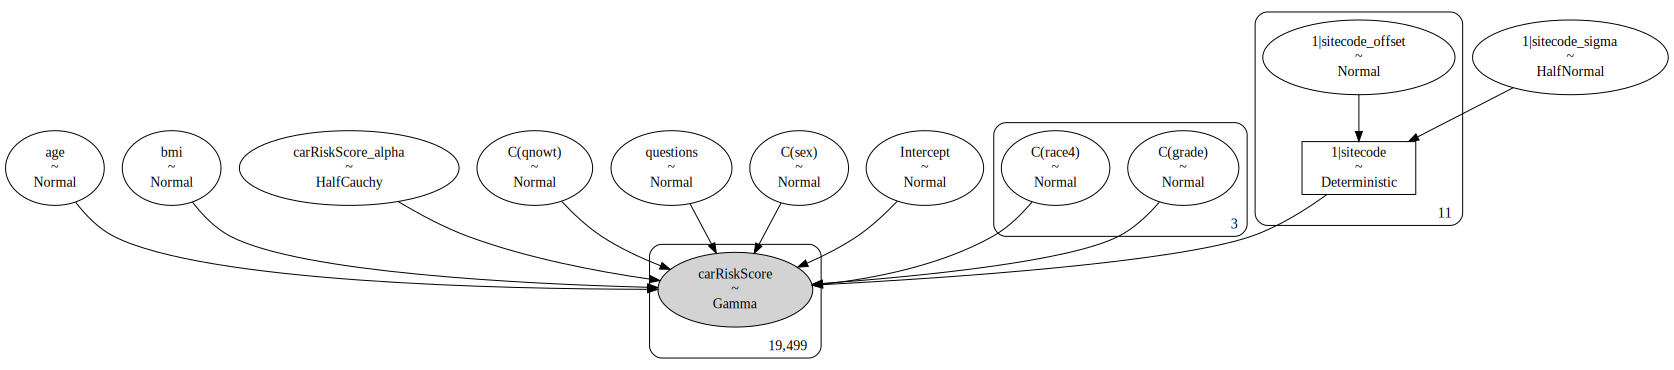

In [142]:
dat2 = dat.copy()
dat2.insert(1, "questions", dat2["q41"])
model_graph = Model('carRiskScore ~ (1|sitecode) + age + C(sex) + C(grade) + C(race4) + bmi + C(qnowt) + questions', data=dat2, family="gamma", link="log")
model_graph.build()

del dat2
model_graph.graph()

### Import Saved Traces

In [9]:
median_impute_trace = az.from_netcdf("./BambiMedImpute")
model_impute_trace = az.from_netcdf("./BambiModelImpute")
no_na_trace = az.from_netcdf("./BambiNoNa")

### Generate Posterior Predictive Dist

In [23]:
median_post_pred = get_site_posterior_pred(dat, model_gamma, median_impute_trace)
model_impute_post_pred = get_site_posterior_pred(dat, model_gamma, model_impute_trace)
no_na_post_pred = get_site_posterior_pred(no_na_dat, model_gamma_no_na, no_na_trace)

### Find Riskiest Sites

In [48]:
#probability that sample from site is riskier than all other sites
sites = dat["sitecode"].unique()
median_risky_probs = posterior_pred_risky_prob(median_post_pred, sites)
model_risky_probs = posterior_pred_risky_prob(model_impute_post_pred, sites)
no_na_risky_probs = posterior_pred_risky_prob(no_na_post_pred, no_na_dat["sitecode"].unique())

In [56]:
risky_probs = median_risky_probs.join(model_risky_probs, rsuffix="2").join(no_na_risky_probs, rsuffix="3")
risky_probs.fillna("Not Included", inplace=True)
risky_probs.columns = ["Median Impute", "Model Impute", "No Impute"]
risky_probs.index.name = "Site"
print(risky_probs.sort_values("Median Impute", ascending=False).to_latex())

\begin{tabular}{lrrl}
\toprule
{} &  Median Impute &  Model Impute &     No Impute \\
Site &                &               &               \\
\midrule
CE   &          0.140 &         0.137 &  Not Included \\
ST   &          0.117 &         0.116 &         0.129 \\
PH   &          0.113 &         0.118 &         0.125 \\
CH   &          0.101 &         0.101 &          0.11 \\
MM   &          0.100 &         0.102 &         0.116 \\
DU   &          0.089 &         0.091 &           0.1 \\
FW   &          0.088 &         0.088 &         0.111 \\
FT   &          0.083 &         0.082 &           0.1 \\
OL   &          0.080 &         0.084 &         0.098 \\
SA   &          0.049 &         0.046 &         0.065 \\
SF   &          0.042 &         0.034 &         0.046 \\
\bottomrule
\end{tabular}



### Model Checking

In [36]:
#model checking, proportion of predictions over threshold
threshold = 200
obs_prop = dat[dat["carRiskScore"] >= threshold].shape[0] / len(dat)
print(obs_prop)
n_draws = 10000
n_obs = 2000
post_prop = (median_post_pred >= threshold).sum() / (len(sites) * n_obs * 1000)
print(post_prop)
post_prop = (model_impute_post_pred >= threshold).sum() / (len(sites) * n_obs * 1000)
print(post_prop)
post_prop = (no_na_post_pred >= threshold).sum() / (no_na_post_pred.shape[0] * n_obs * 1000)
print(post_prop)

0.10939022513975076
0.08281336363636364
0.07587672727272728
0.06944375


### KDE of Posterior Pred. Dist

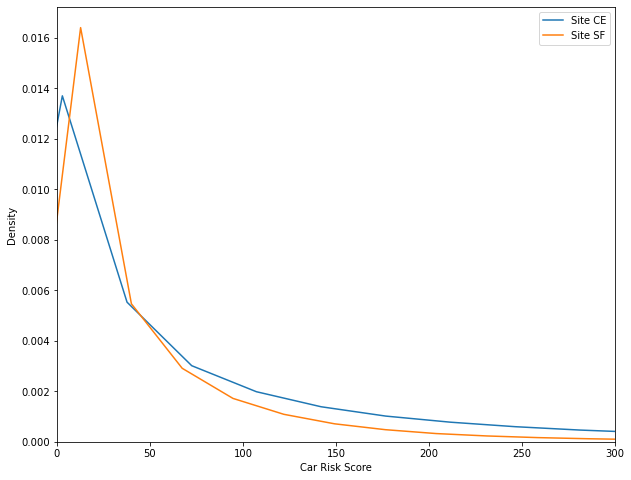

In [55]:
#for idx, site in enumerate(sites):
#    _ = sns.kdeplot(median_post_pred[idx,::10,:].flatten(), label=site, bw_adjust=1)
_ = sns.kdeplot(median_post_pred[0,].flatten(), label="Site CE", bw_adjust=1.2)
_ = sns.kdeplot(median_post_pred[-2,].flatten(), label="Site SF", bw_adjust=1.2)
_ = plt.xlabel("Car Risk Score")
_ = plt.legend()
_ = plt.xlim((0, 300))
_ = plt.gcf().set_size_inches((10, 8))
plt.savefig("./posterior_predictive.png")

### Posterior Means of Parameters

In [11]:
posterior_sum_median = posterior_param_intervals(median_impute_trace)
posterior_sum_model = posterior_param_intervals(model_impute_trace)
posterior_sum_no_na = posterior_param_intervals(no_na_trace)

In [ ]:
posterior_variable_summary = (posterior_sum_median
    .join(posterior_sum_model, how="left", rsuffix="2")
    .join(posterior_sum_no_na, how="left", rsuffix="3"))
posterior_variable_summary = posterior_variable_summary[["Post", "Post2", "Post3"]]
posterior_variable_summary.columns = [["Posterior Mean and 2.5-97.5 Percentiles"] * 3, ["Median Impute", "Model Impute", "No Impute"]]
posterior_variable_summary.fillna("Not Included", inplace=True)
#posterior_variable_summary
#print(posterior_variable_summary.to_latex(bold_rows=True, multirow=True))



In [15]:
posterior_sites_median = site_intercept_intervals(median_impute_trace)
posterior_sites_model = site_intercept_intervals(model_impute_trace)
posterior_sites_na_na = site_intercept_intervals(no_na_trace)

In [ ]:
posterior_site_summary = (posterior_sites_median
    .join(posterior_sites_model, how="left", rsuffix="2")
    .join(posterior_sites_na_na, how="left", rsuffix="3"))
posterior_site_summary = posterior_site_summary[["Post", "Post2", "Post3"]]
posterior_site_summary.columns = [["Posterior Mean and 2.5-97.5 Percentiles"] * 3, ["Median Impute", "Model Impute", "No Impute"]]
posterior_site_summary.fillna("Not Included", inplace=True)
posterior_site_summary.index.name = "Site"
posterior_site_summary
print(posterior_site_summary.to_latex(bold_rows=True, multirow=True))

### Various Plots for Report

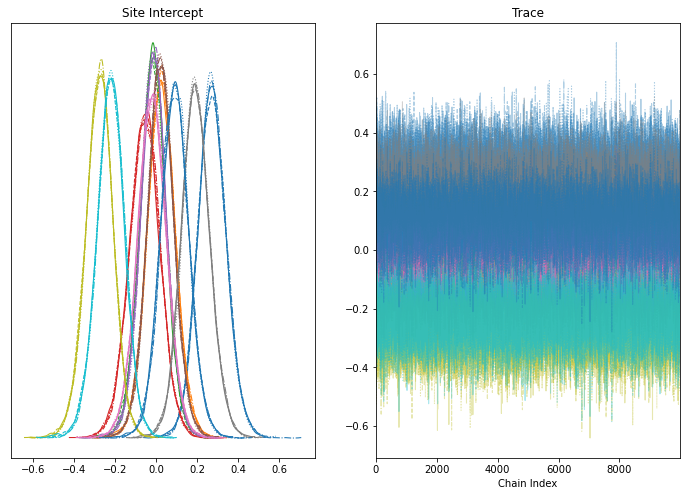

In [11]:
axs = az.plot_trace(median_impute_trace["posterior"]["1|sitecode"][:,:,], figsize=(10, 7))
_ = axs[0][0].set_title("Site Intercept")
_ = axs[0][1].set_title("Trace")
_ = axs[0][1].set_xlabel("Chain Index")
_ = plt.gcf().set_size_inches((12, 8))
plt.savefig("./intercept_trace.png")

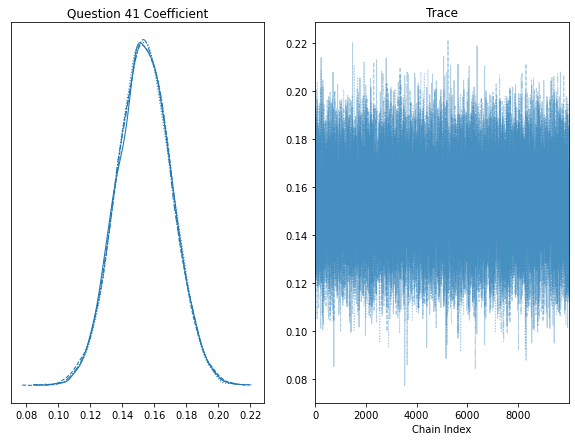

In [10]:
axs = az.plot_trace(median_impute_trace["posterior"]["q41"], figsize=(10, 7))
_ = axs[0][0].set_title("Question 41 Coefficient")
_ = axs[0][1].set_title("Trace")
_ = axs[0][1].set_xlabel("Chain Index")
plt.savefig("./q41_trace.png")

In [35]:
root = "../data/"
survNA = pd.read_csv(root+"survSomeNA2017.csv", index_col=0).sort_values(["year", "sitecode"])
survNA.head()

,age,bmi,grade,q13,q18,q25,q26,q47,q57,qnowt,...,q69,q46,q19,q12,q8,q9,q41,q40,q27,carRiskScore
387614,4.0,21.469686,2.0,NaN,NaN,2.0,2.0,2.0,NaN,NaN,...,NaN,4.0,NaN,1.0,3.0,2.0,2.0,3.0,NaN,157.894737
387615,4.0,NaN,NaN,NaN,NaN,2.0,2.0,1.0,2.0,NaN,...,1.0,1.0,2.0,1.0,4.0,1.0,1.0,5.0,NaN,26.315789
387616,4.0,20.701227,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,2.0,NaN,NaN,4.0,5.0,4.0,5.0,NaN,815.789474
387617,4.0,21.474561,NaN,NaN,NaN,2.0,2.0,1.0,2.0,NaN,...,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,NaN,78.947368
387618,5.0,92.631374,1.0,NaN,NaN,1.0,2.0,6.0,NaN,NaN,...,7.0,3.0,1.0,NaN,2.0,5.0,NaN,5.0,NaN,552.631579


In [36]:
survNA.shape

(20523, 35)

/tmp/ipykernel_13731/2611788976.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  surv2017 = surv2017.fillna(surv2017.median())


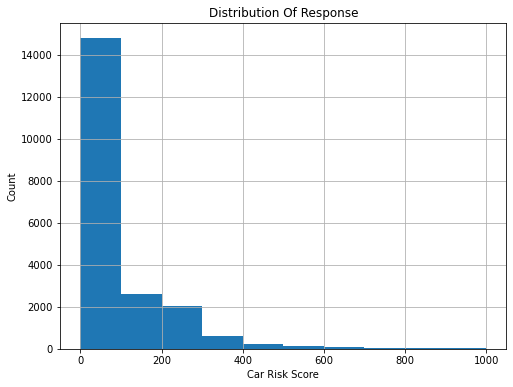

In [80]:
surv2017 = pd.read_csv(root + "survSomeNA2017.csv").drop(["Unnamed: 0"], axis=1)
surv2017 = surv2017.fillna(surv2017.median())
_ = surv2017.hist("carRiskScore")
_ = plt.ylabel("Count")
_ = plt.xlabel("Car Risk Score")
_ = plt.title("Distribution Of Response")
_ = plt.gcf().set_size_inches((8, 6))
_ = plt.savefig("./response.png")

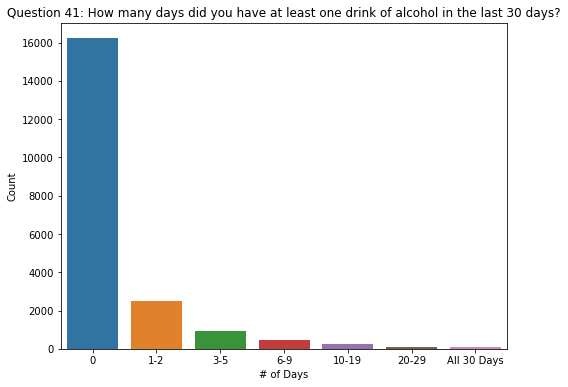

In [90]:
_ = sns.countplot(x=surv2017["q41"])
_ = plt.ylabel("Count")
_ = plt.gca().set_xticklabels(["0", "1-2", "3-5", "6-9", "10-19", "20-29", "All 30 Days"])
_ = plt.xlabel("# of Days")
_ = plt.title("Question 41: How many days did you have at least one drink of alcohol in the last 30 days?")
_ = plt.gcf().set_size_inches((8, 6))
_ = plt.savefig("./q41.png")

### Testing below (ignore)

In [ ]:
#generate sample from data just for testing
#dat_2005 = dat_2005.sample(2000, random_state=551)
#dat_2005["car_risk_score"] = dat_2005["car_risk_score"] + 1

root = "../data/"
survNoNA = pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0).sort_values(["year", "sitecode"])
survNoNA = survNoNA.sample(2000, random_state=551)
survNoNA["carRiskScore"] = survNoNA["carRiskScore"] + 1
county_idxs, counties = pd.factorize(survNoNA["sitecode"]) # needed for hierarchical model
year_idxs, years = pd.factorize(survNoNA["year"])
coords = {
    "county": counties,
    "year": years,
    "obs_id": np.arange(len(county_idxs)),
}

In [ ]:
with pm.Model(coords=coords) as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    year_idx = pm.Data("year_idx", year_idxs, dims="obs_id")

    # Define priors
    #sigma = pm.Gamma("sigma", alpha=.01, beta=.01)
    intercept = pm.Normal("Intercept", 0, sigma=.001, dims="year")
    X = survNoNA[["age", "bmi"]]#survNoNA.drop(["carRiskScore", "sitecode"], axis=1)
    #beta = pm.Normal("beta", 1, sigma=10, shape=X.shape[1])
    question_betas = []
    for i, q in enumerate(X.columns):
        q_beta = pm.Normal("beta" + str(i), 1, sigma=10, dims="county")
        question_betas.append(q_beta)
    #mu_est = intercept[year_idx]
    mu_est = None
    for i, b in enumerate(question_betas):
        if mu_est is None:
            mu_est = b[county_idx] * X.iloc[:,i]
        else:
            mu_est += b[county_idx] * X.iloc[:,i]

    # Define likelihood
    likelihood = pm.Gamma(
        "y",
        #mu=intercept[county_idx] + pm.math.dot(X, beta),
        alpha=intercept[year_idx] + mu_est,
        beta=100,
        observed=dat_2005["car_risk_score"], dims="obs_id")
    #print(pm.distributions.shape_utils.to_tuple(likelihood.shape))
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    #trace = pm.sample(3000, return_inferencedata=True)

    #pm.sample_posterior_predictive(trace, var_names=["x"])

In [ ]:
with model:
    trace = pm.sample(100, return_inferencedata=True, target_accept=0.9)
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])

In [ ]:
with model:
    approx = pm.fit()

In [ ]:
approx.sample()[0]

Model Checking using extreme risk scores

In [ ]:
threshold = 500
y_pred = ppc["y"].ravel()
(y_pred > threshold).sum() / y_pred.shape[0] * 100

0.8106333333333333

In [ ]:
(d["car_risk_score"] > threshold).sum() / d.shape[0] * 100

5.35

Posteriors

In [ ]:
trace["posterior"]["Intercept"].mean(axis=1).mean(axis=0)

In [ ]:
trace["posterior"]["beta"].mean(axis=1).mean(axis=0)

In [ ]:
ppc

In [ ]:
ax = az.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(12, 10))
_ = ax.set_xlim((-10, 1000))

In [ ]:
trace

In [ ]:
_ = az.plot_trace(trace["posterior"]["beta40"][:,:,], figsize=(10, 7))